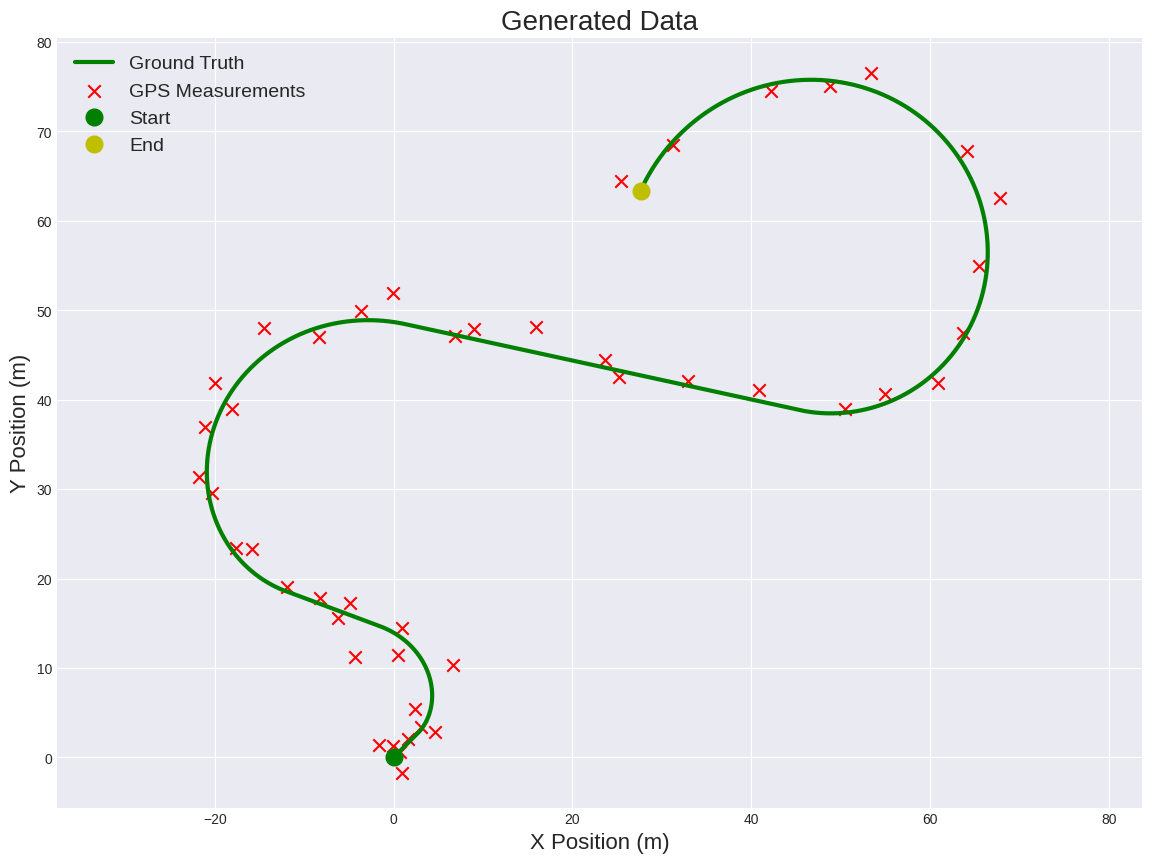

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DATA SIMULATION (from previous step) ---

# Simulation parameters
IMU_FREQUENCY = 400  # Hz
GPS_FREQUENCY = 0.75    # Hz
TOTAL_TIME = 60      # seconds

# Time steps
dt_imu = 1.0 / IMU_FREQUENCY
dt_gps = 1.0 / GPS_FREQUENCY

# Noise parameters
accel_noise_std = 0.2  # m/s^2
gyro_noise_std = 0.02  # rad/s

gps_noise_std_x = 1.5  # meters
gps_noise_std_y = 1.5  # meters

# Initial state
initial_heading = np.pi/4
initial_velocity = 0.5

def generate_turning_trajectory(total_time, dt):
    """Generates a ground truth trajectory with turns."""
    num_steps = int(total_time / dt)
    # Ground truth state: [x, y, theta, v, theta_dot]
    # We will not use theta_dot in the EKF since it is measured directly from the IMU.
    true_state = np.zeros((num_steps, 5))
    true_state[0] = [0, 0, initial_heading, initial_velocity, 0]

    # Control inputs for the simulation
    forward_acceleration = 0.1
    angular_velocity_input = np.zeros(num_steps)
    angular_velocity_input[int(5/dt):int(15/dt)] = 0.2
    angular_velocity_input[int(20/dt):int(35/dt)] = -0.2
    angular_velocity_input[int(45/dt):int(60/dt)] = 0.3

    for i in range(1, num_steps):
        x, y, theta, v, theta_dot = true_state[i-1]
        v_new = v + forward_acceleration * dt
        theta_dot_new = angular_velocity_input[i]
        theta_new = theta + theta_dot * dt
        x_new = x + v * np.cos(theta) * dt
        y_new = y + v * np.sin(theta) * dt
        true_state[i] = [x_new, y_new, theta_new, v_new, theta_dot_new]
    return true_state

def simulate_sensors(ground_truth):
    """Generates IMU and GPS data from the ground truth trajectory."""
    num_steps = ground_truth.shape[0]

    # IMU measurements (control inputs for EKF)
    # u = [forward_acceleration, angular_velocity]
    imu_measurements = np.zeros((num_steps, 2))
    for i in range(1, num_steps):
        v_prev, v_curr = ground_truth[i-1, 3], ground_truth[i, 3]
        accel = (v_curr - v_prev) / dt_imu
        imu_measurements[i, 0] = accel + np.random.normal(0, accel_noise_std)
        theta_dot = ground_truth[i, 4]
        imu_measurements[i, 1] = theta_dot + np.random.normal(0, gyro_noise_std)

    # GPS measurements
    gps_indices = [i for i in range(0, num_steps, int(dt_gps/dt_imu))]
    gps_measurements = ground_truth[gps_indices, :2] + \
                       np.random.normal(0, [gps_noise_std_x, gps_noise_std_y], (len(gps_indices), 2))

    return imu_measurements, gps_measurements, gps_indices

# --- Main Execution ---

# Generate the data
ground_truth = generate_turning_trajectory(TOTAL_TIME, dt_imu)
imu_data, gps_data, gps_indices = simulate_sensors(ground_truth)

# Visualize the results
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 10))

# Ground Truth
ax.plot(ground_truth[:, 0], ground_truth[:, 1], 'g', label='Ground Truth', linewidth=3)
# GPS Measurements
ax.scatter(gps_data[:, 0], gps_data[:, 1], c='r', marker='x', s=80, label='GPS Measurements')

# Markers
ax.plot(ground_truth[0, 0], ground_truth[0, 1], 'go', markersize=12, label='Start')
ax.plot(ground_truth[-1, 0], ground_truth[-1, 1], 'yo', markersize=12, label='End')

ax.set_title('Generated Data', fontsize=20)
ax.set_xlabel('X Position (m)', fontsize=16)
ax.set_ylabel('Y Position (m)', fontsize=16)
ax.legend(fontsize=14)
ax.axis('equal')
ax.grid(True)

plt.show()

# The generated data is stored in the following variables:
# ground_truth_state: A NumPy array where each row is the state [x, y, theta, v, theta_dot] at each IMU time step.
# imu_measurements: A dictionary containing timestamps, accelerometer, and gyroscope readings.
# gps_measurements: A dictionary containing timestamps and noisy position measurements.

## IMU for State Propagation in an EKF

In a typical Extended Kalman Filter (EKF) setup for fusing IMU and GPS data, the **IMU** is used for the high-frequency **prediction (or propagation) step**, while the **GPS** is used for the lower-frequency **update (or correction) step**.

***

### Rationale for Sensor Roles 🧐

This division of labor leverages the unique strengths of each sensor to produce a state estimate that is more accurate and robust than what either sensor could provide alone.

* **IMU (Prediction):** The IMU provides measurements of acceleration and angular velocity at a very high rate (e.g., 400 Hz). These are relative measurements that describe *changes* in the system's state. By integrating these measurements over the short time intervals between GPS updates, we can create a smooth, high-frequency estimate of the system's trajectory. However, this integration process accumulates small sensor errors over time, leading to a phenomenon known as **drift**. Therefore, the IMU is excellent for short-term relative tracking but unreliable for long-term absolute positioning.

* **GPS (Update):** The GPS provides direct measurements of absolute position. While these readings are noisy and arrive at a much lower frequency (e.g., 5 Hz), they do not suffer from cumulative drift. Each GPS measurement provides a ground-truth reference that can be used to **correct the drift** accumulated by the IMU-based prediction.

By combining these two sensors, the EKF uses the IMU to fill in the gaps between GPS readings and then uses each new GPS reading to anchor the estimate and eliminate accumulated error, achieving the best of both worlds.

***

### State Transition Function

The state transition function, denoted as $f(\cdot)$, mathematically defines how the system's state evolves from one time step to the next based on the IMU inputs.

Our state vector ($x$) is defined as:
$$x = [p_x, p_y, \theta, v]^T$$
where:
* $p_x, p_y$: Position coordinates in the x and y axes.
* $\theta$: Orientation (yaw angle).
* $v$: Forward velocity.

The inputs ($u_k$) from the IMU at time step $k$ are the measured forward acceleration ($a_m$) and measured angular velocity ($\omega_m$). Think of it like this: The position and velocity of a car are its state. The driver turning the steering wheel and pressing the accelerator are the inputs. You use the inputs in your physics model to predict how the car's state will change.

Assuming a constant velocity and constant turn rate model over the small time interval $\Delta t$, the state transition function to predict the state at time $k$ from the state at $k-1$ is:

$$
x_k = f(x_{k-1}, u_k) =
\begin{bmatrix}
p_{x, k-1} + v_{k-1} \cos(\theta_{k-1}) \Delta t \\
p_{y, k-1} + v_{k-1} \sin(\theta_{k-1}) \Delta t \\
\theta_{k-1} + \omega_m \Delta t \\
v_{k-1} + a_m \Delta t \\
\end{bmatrix}
$$

#### Breakdown of the Function:

* **Position Update ($p_{x,k}, p_{y,k}$):** The new position is calculated by adding the displacement to the previous position. The displacement is found by projecting the previous velocity ($v_{k-1}$) onto the x and y axes using the previous orientation ($\theta_{k-1}$) and multiplying by the time step $\Delta t$.

* **Orientation Update ($\theta_k$):** The new orientation is the previous orientation plus the change in angle, which is the measured angular velocity from the gyroscope ($\omega_m$) multiplied by the time step.

* **Velocity Update ($v_k$):** The new forward velocity is the previous velocity plus the change in velocity, as calculated from the measured forward acceleration from the accelerometer ($a_m$) multiplied by the time step.

## EKF Jacobians: F and H 📐

In the Extended Kalman Filter, we linearize our non-linear models around the current best estimate of the state. This is done by computing matrices of partial derivatives, known as Jacobians. These Jacobians, $F_k$ and $H_k$, are essential for propagating the state's uncertainty (covariance) correctly.

***

### State Transition Jacobian ($F_k$)

The matrix $F_k$ is the Jacobian of the state transition function $f(x, u)$ with respect to the state vector $x$. It answers the question: "How does a small change in each element of the state vector affect each element of the *next* state?"

$F_k = \frac{\partial f}{\partial x} \Bigg|_{\hat{x}_{k-1}^+, u_{k-1}}$

Given our 4D state vector $x = [p_x, p_y, \theta, v]^T$ and state transition function $f$, we compute the 4x4 matrix $F_k$ as follows:

$$
F_k = \begin{bmatrix}
\frac{\partial f_1}{\partial p_x} & \frac{\partial f_1}{\partial p_y} & \frac{\partial f_1}{\partial \theta} & \frac{\partial f_1}{\partial v} \\
\frac{\partial f_2}{\partial p_x} & \frac{\partial f_2}{\partial p_y} & \frac{\partial f_2}{\partial \theta} & \frac{\partial f_2}{\partial v} \\
\frac{\partial f_3}{\partial p_x} & \frac{\partial f_3}{\partial p_y} & \frac{\partial f_3}{\partial \theta} & \frac{\partial f_3}{\partial v} \\
\frac{\partial f_4}{\partial p_x} & \frac{\partial f_4}{\partial p_y} & \frac{\partial f_4}{\partial \theta} & \frac{\partial f_4}{\partial v}
\end{bmatrix}
$$

Calculating these partial derivatives from our motion model yields:

$$
F_k = \begin{bmatrix}
1 & 0 & -v \sin(\theta) \Delta t & \cos(\theta) \Delta t \\
0 & 1 & v \cos(\theta) \Delta t & \sin(\theta) \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

**Key Insight:** Notice that $F_k$ depends on the current state variables $v$ and $\theta$. This is the core of the **Extended** Kalman Filter. Because the matrix changes with the state, it must be **recalculated at every single time step** using the most recent state estimate.

***

### Measurement Jacobian ($H_k$)

The matrix $H_k$ is the Jacobian of the measurement function $h(x)$ with respect to the state vector $x$. It maps the uncertainty from the state space to the measurement space.

$H_k = \frac{\partial h}{\partial x} \Bigg|_{\hat{x}_k^-}$

Our measurement function, $h(x)$, maps the state to a GPS position measurement $[p_x, p_y]^T$. Since our state is $x = [p_x, p_y, \theta, v]^T$ and our measurement is 2D, the Jacobian $H_k$ will be a 2x4 matrix.

$$
H_k = \begin{bmatrix}
\frac{\partial h_1}{\partial p_x} & \frac{\partial h_1}{\partial p_y} & \frac{\partial h_1}{\partial \theta} & \frac{\partial h_1}{\partial v} \\
\frac{\partial h_2}{\partial p_x} & \frac{\partial h_2}{\partial p_y} & \frac{\partial h_2}{\partial \theta} & \frac{\partial h_2}{\partial v}
\end{bmatrix}
$$

Calculating these partial derivatives gives us:

$$
H_k = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$

**Key Insight:** Our measurement function $h(x) = [p_x, p_y]^T$ is **already a linear function** of the state. Because of this, its Jacobian ($H_k$) is a **constant matrix**. It does not depend on the current state and therefore does not need to be recalculated in every loop of the filter, which is a convenient simplification.

## Justifying the 4-State Model

The choice to use a 4-dimensional state vector, **$x = [p_x, p_y, \theta, v]^T$**, is based on a crucial distinction between a system's **state** and its **control inputs**.

* A **state variable** is an internal property of the system that the filter needs to estimate. The filter uses a model to predict how this variable evolves over time.
* A **control input** is an external measurement or command that causes a change in the state.

In our case, the IMU's measurements—forward acceleration ($a_m$) and angular velocity ($\omega_m$)—are best treated as control inputs ($u$). They are the forces driving the system. The state, on the other hand, is the vehicle's resulting pose and velocity.

Treating angular velocity ($\omega$) as a state variable in a 5D model where its prediction is simply $\omega_k = \omega_m$ is flawed because the state is not being propagated based on a model of its own dynamics. Instead, it's being completely replaced by an external measurement. This prevents the EKF from properly estimating the uncertainty (covariance) of that variable. The 4-state model correctly uses the IMU measurements as inputs to predict the evolution of the vehicle's position, orientation, and velocity.

***

## The Importance of Tracking IMU Bias in the Real World 🌍

In any real-world application, it's **absolutely essential** to track the IMU's accelerometer and gyroscope biases.

* **What is Bias?** Bias is a systematic, persistent error in a sensor's output. Even when perfectly stationary, a real gyroscope will report a small, non-zero rotation, and an accelerometer will report a small, non-zero acceleration. This offset can also drift slowly over time.

* **Why It's Critical:** The EKF's prediction step **integrates** the IMU measurements. Ignoring a constant bias leads to catastrophic error growth:
    * A constant **gyroscope bias** integrates into a continuously growing orientation error, making the filter believe it's perpetually turning.
    * A constant **accelerometer bias** is integrated twice (first into velocity, then into position), causing a position error that grows quadratically over time ($error \propto t^2$).

To combat this, the state vector is **augmented** to include the bias terms (e.g., $x = [p_x, p_y, \theta, v, b_a, b_{\omega}]^T$). The EKF then estimates these biases online, using the absolute GPS data to observe the effects of the drift and correct the bias estimates.

***

## Why We Can Ignore Bias in Our Simulation ✅

We can confidently ignore bias in our current simulation for one simple reason: **our synthetic sensor data was created without any bias.**

The process for generating our IMU data was:

`IMU_Reading = True_Value + Zero_Mean_Random_Noise`

We added random noise that averages to zero over time, but we did not include a persistent offset. Our simulated IMU is an idealized sensor. Since there is no bias present in the data, there is no bias for the filter to estimate.

This approach is standard for learning and validation. It allows us to first confirm that the core EKF fusion logic is working correctly without the added complexity of bias estimation. A great next step for a more realistic simulation would be to introduce a bias term into the data generation and then augment the EKF's state vector to estimate it.

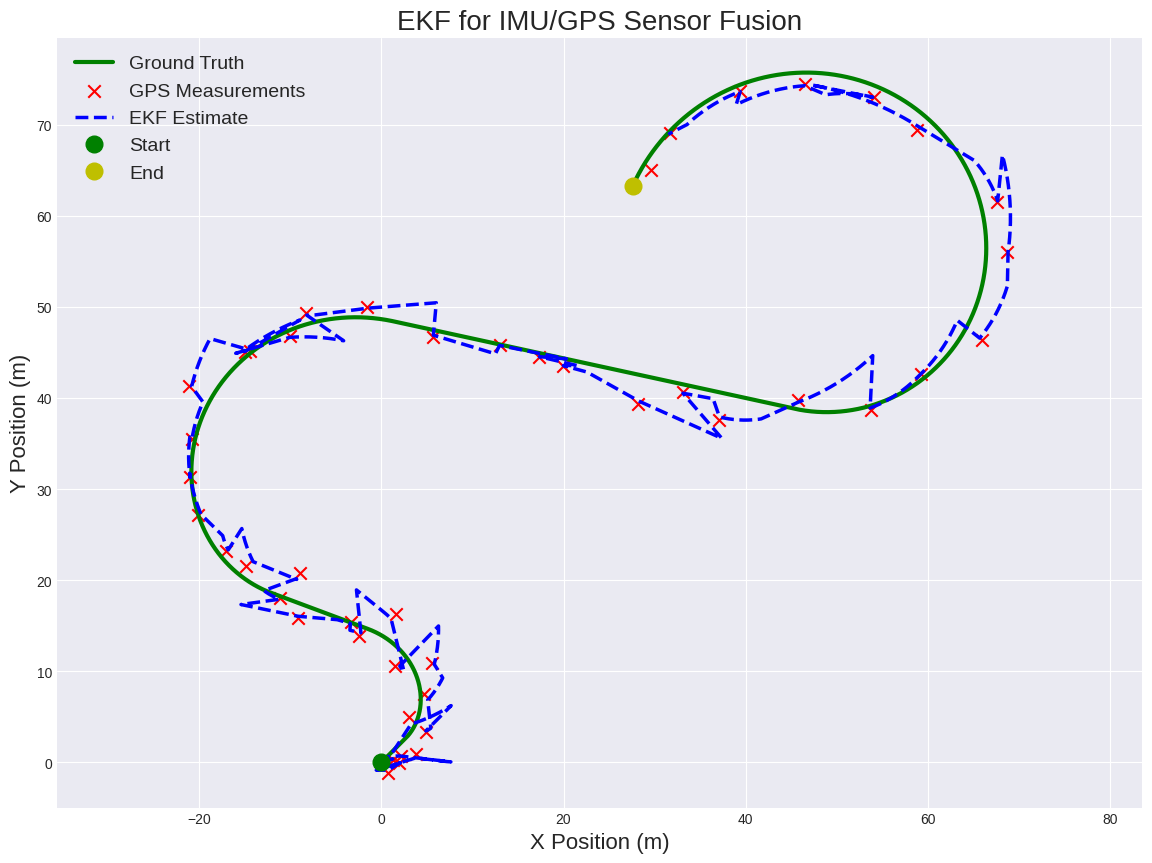

In [ ]:
# --- 2. EXTENDED KALMAN FILTER IMPLEMENTATION ---

def run_ekf(imu_measurements, gps_measurements, gps_indices):
    """
    Implements the Extended Kalman Filter based on the provided algorithm.
    """
    # State vector: [x, y, theta, v]
    n_states = 4

    # EKF Initialization (Step 2 from algorithm)
    # Initial state estimate (can be from first GPS reading or prior knowledge)
    x_est = np.zeros(n_states)
    x_est[0] = gps_measurements[0, 0]
    x_est[1] = gps_measurements[0, 1]

    # Initial estimation-error covariance
    P_est = np.diag([10, 10, 0.1, 0.1])

    # Noise Covariance Matrices
    # Process noise Q (uncertainty in the motion model)
    Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 0.5])**2
    # Measurement noise R (uncertainty from the GPS)
    R = np.diag([gps_noise_std_x**2, gps_noise_std_y**2])

    # Store history of estimates
    x_est_history = [x_est.copy()]
    P_est_history = [P_est.copy()]

    gps_meas_idx = 0

    # Main Loop (Step 3 from algorithm)
    for i in range(1, len(imu_measurements)):
        # Get control input u = [a_m, omega_m]
        u = imu_measurements[i]

        # --- (a) & (b) Time Update / Prediction ---

        # Previous state
        x_prev = x_est_history[-1]
        theta_prev = x_prev[2]
        v_prev = x_prev[3]

        # Predict state estimate (using the state transition function)
        x_pred = np.zeros(n_states)
        x_pred[0] = x_prev[0] + v_prev * np.cos(theta_prev) * dt_imu
        x_pred[1] = x_prev[1] + v_prev * np.sin(theta_prev) * dt_imu
        x_pred[2] = x_prev[2] + u[1] * dt_imu
        x_pred[3] = x_prev[3] + u[0] * dt_imu

        # Compute Jacobian F
        F = np.array([
            [1, 0, -v_prev * np.sin(theta_prev) * dt_imu, np.cos(theta_prev) * dt_imu],
            [0, 1,  v_prev * np.cos(theta_prev) * dt_imu, np.sin(theta_prev) * dt_imu],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

        # Predict estimation-error covariance
        P_pred = F @ P_est @ F.T + Q

        x_est = x_pred
        P_est = P_pred

        # --- (c) & (d) Measurement Update / Correction ---

        # Check if a GPS measurement is available at this time step
        if i in gps_indices:
            # Get GPS measurement
            z = gps_measurements[gps_meas_idx]
            gps_meas_idx += 1

            # Compute Jacobian H
            H = np.array([
                [1, 0, 0, 0],
                [0, 1, 0, 0]
            ])

            # Calculate Kalman Gain K
            innovation_cov = H @ P_est @ H.T + R
            K = P_est @ H.T @ np.linalg.inv(innovation_cov)

            # Update state estimate
            innovation = z - H @ x_est
            x_est = x_est + K @ innovation

            # Update estimation-error covariance
            P_est = (np.eye(n_states) - K @ H) @ P_est

        # Save current estimate
        x_est_history.append(x_est.copy())
        P_est_history.append(P_est.copy())

    return np.array(x_est_history), np.array(P_est_history)


# --- 3. MAIN EXECUTION AND VISUALIZATION ---

# Generate the data
ground_truth = generate_turning_trajectory(TOTAL_TIME, dt_imu)
imu_data, gps_data, gps_indices = simulate_sensors(ground_truth)

# Run the Extended Kalman Filter
ekf_estimates, ekf_covariances = run_ekf(imu_data, gps_data, gps_indices)

# Visualize the results
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 10))

# Ground Truth
ax.plot(ground_truth[:, 0], ground_truth[:, 1], 'g', label='Ground Truth', linewidth=3)
# GPS Measurements
ax.scatter(gps_data[:, 0], gps_data[:, 1], c='r', marker='x', s=80, label='GPS Measurements')
# EKF Estimate
ax.plot(ekf_estimates[:, 0], ekf_estimates[:, 1], 'b--', label='EKF Estimate', linewidth=2.5)

# Markers
ax.plot(ground_truth[0, 0], ground_truth[0, 1], 'go', markersize=12, label='Start')
ax.plot(ground_truth[-1, 0], ground_truth[-1, 1], 'yo', markersize=12, label='End')

ax.set_title('EKF for IMU/GPS Sensor Fusion', fontsize=20)
ax.set_xlabel('X Position (m)', fontsize=16)
ax.set_ylabel('Y Position (m)', fontsize=16)
ax.legend(fontsize=14)
ax.axis('equal')
ax.grid(True)

plt.show()

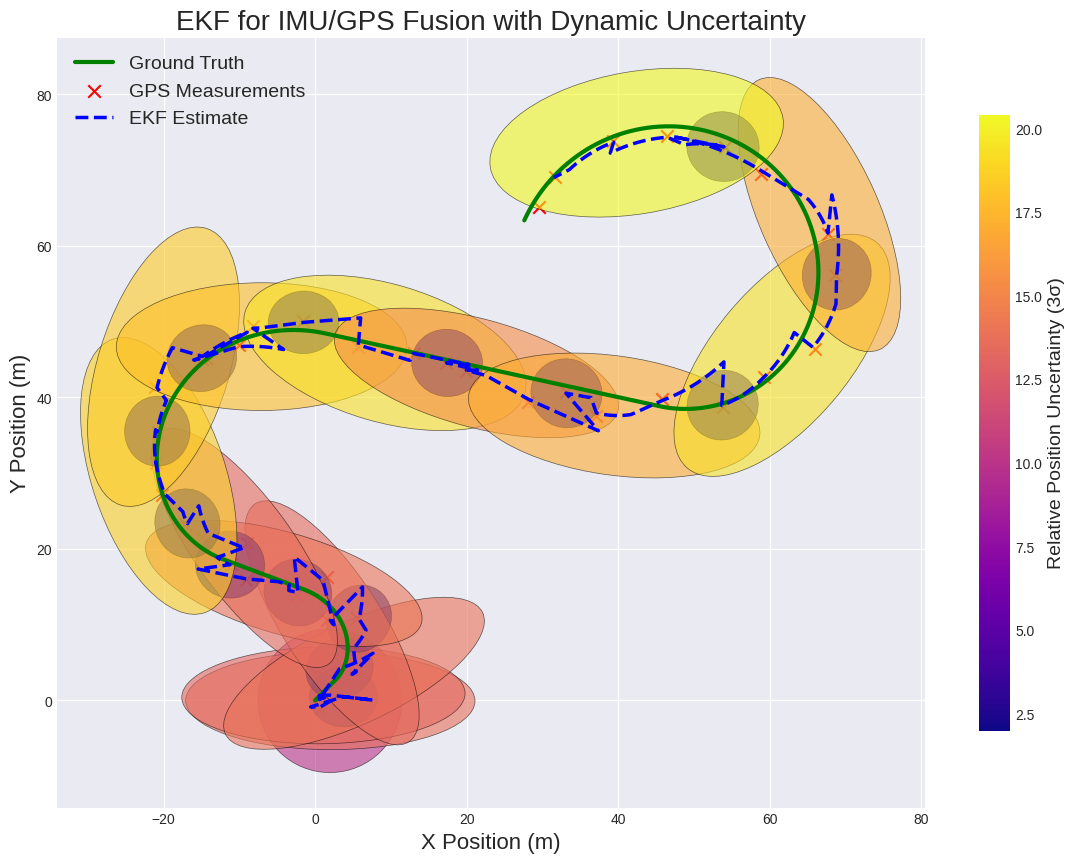

In [ ]:
from matplotlib.patches import Ellipse
from matplotlib import cm # Import the colormap module

def plot_covariance_ellipse(x, P, ax, n_std=3.0, **kwargs):
    """
    Plots the covariance ellipse for a 2D position.
    """
    # Get the 2x2 position covariance matrix
    P_pos = P[0:2, 0:2]

    # Calculate eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eig(P_pos)

    # Get the angle of the largest eigenvector
    angle = np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0])

    # Create the ellipse centered at the state's position
    ellipse = Ellipse(xy=x[0:2],
                      width=2 * n_std * np.sqrt(eigenvals[0]),
                      height=2 * n_std * np.sqrt(eigenvals[1]),
                      angle=np.degrees(angle),
                      **kwargs)
    ax.add_patch(ellipse)

# Visualize
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 10))

# Plot trajectories
ax.plot(ground_truth[:, 0], ground_truth[:, 1], 'g', label='Ground Truth', linewidth=3)
ax.scatter(gps_data[:, 0], gps_data[:, 1], c='r', marker='x', s=80, label='GPS Measurements')
ax.plot(ekf_estimates[:, 0], ekf_estimates[:, 1], 'b--', label='EKF Estimate', linewidth=2.5)

# Plot uncertainty ellipses at intervals
# Plotting every ellipse would be too cluttered, so we plot one every 2 seconds
plot_interval = 2 * IMU_FREQUENCY
indices_to_plot = range(0, len(ekf_estimates), plot_interval)

uncertainty_values = []
for i in indices_to_plot:
    P_pos = ekf_covariances[i, 0:2, 0:2]
    # Use the determinant as a measure of the ellipse area/uncertainty
    uncertainty = np.sqrt(np.linalg.det(P_pos))
    uncertainty_values.append(uncertainty)

# Normalize these values to the range [0, 1] for the colormap
min_unc = min(uncertainty_values)
max_unc = max(uncertainty_values)
norm = plt.Normalize(vmin=min_unc, vmax=max_unc)
cmap = plt.get_cmap('plasma') # Choose a visually distinct colormap

# --- Step 2: Plot ellipses with colors mapped to uncertainty ---
for i in indices_to_plot:
    # Get the normalized color for the current ellipse
    P_pos = ekf_covariances[i, 0:2, 0:2]
    uncertainty = np.sqrt(np.linalg.det(P_pos))
    color = cmap(norm(uncertainty))

    plot_covariance_ellipse(ekf_estimates[i], ekf_covariances[i], ax,
                            n_std=3.0,
                            facecolor=color, alpha=0.6, # Use the dynamic color
                            edgecolor='k', linewidth=0.5,
                            zorder=1)

# --- Step 3: Add a colorbar to explain the new color scheme ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8) # Add colorbar to the plot
cbar.set_label('Relative Position Uncertainty (3σ)', fontsize=14)

ax.set_title('EKF for IMU/GPS Fusion with Dynamic Uncertainty', fontsize=20)
ax.set_xlabel('X Position (m)', fontsize=16)
ax.set_ylabel('Y Position (m)', fontsize=16)
ax.legend(fontsize=14)
ax.axis('equal')
ax.grid(True)

plt.show()


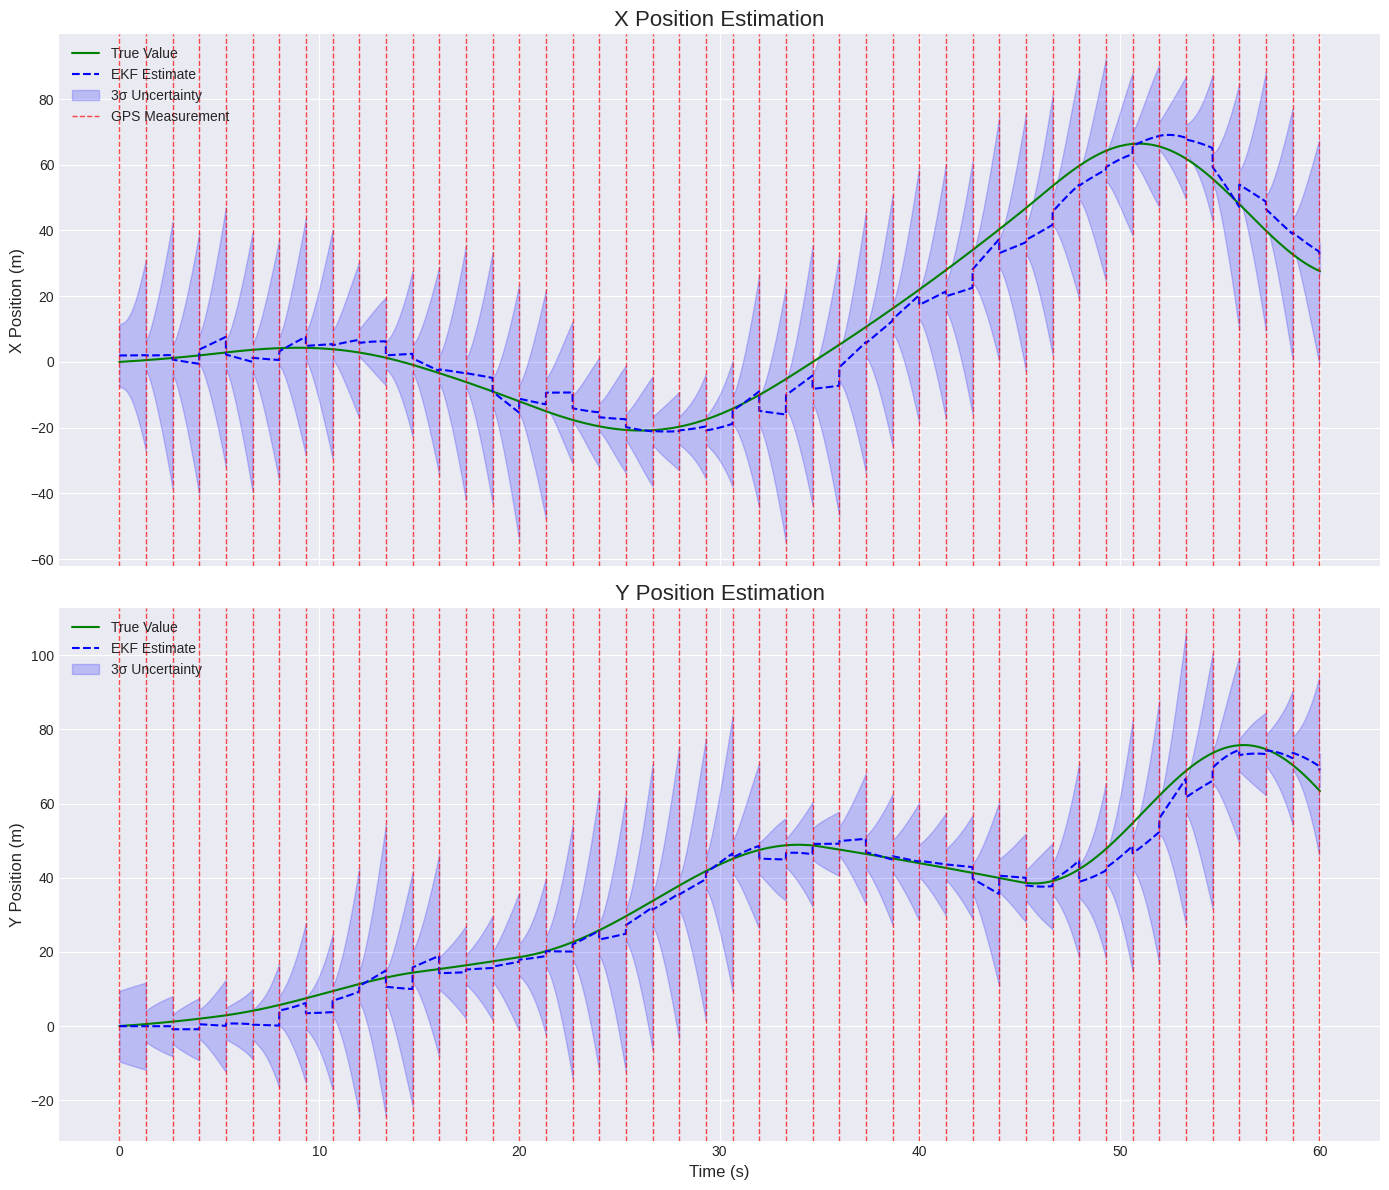

In [ ]:
# Create time axis for plotting
time_axis = np.arange(len(ekf_estimates)) * dt_imu

# Extract 3-sigma uncertainties (3 * standard deviation)
n_std = 3.0
std_x = n_std * np.sqrt(ekf_covariances[:, 0, 0])
std_y = n_std * np.sqrt(ekf_covariances[:, 1, 1])

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
plt.style.use('seaborn-v0_8-darkgrid')

# --- Plot 1: X Position ---
axs[0].plot(time_axis, ground_truth[:, 0], 'g', label='True Value')
axs[0].plot(time_axis, ekf_estimates[:, 0], 'b--', label='EKF Estimate')
axs[0].fill_between(time_axis,
                    ekf_estimates[:, 0] - std_x,
                    ekf_estimates[:, 0] + std_x,
                    color='b', alpha=0.2, label='3σ Uncertainty')
axs[0].set_title('X Position Estimation', fontsize=16)
axs[0].set_ylabel('X Position (m)', fontsize=12)
axs[0].grid(True)

# --- Plot 2: Y Position ---
axs[1].plot(time_axis, ground_truth[:, 1], 'g', label='True Value')
axs[1].plot(time_axis, ekf_estimates[:, 1], 'b--', label='EKF Estimate')
axs[1].fill_between(time_axis,
                    ekf_estimates[:, 1] - std_y,
                    ekf_estimates[:, 1] + std_y,
                    color='b', alpha=0.2, label='3σ Uncertainty')
axs[1].set_title('Y Position Estimation', fontsize=16)
axs[1].set_xlabel('Time (s)', fontsize=12)
axs[1].set_ylabel('Y Position (m)', fontsize=12)
axs[1].grid(True)

# Draw vertical lines for GPS measurements on both plots
for idx in gps_indices:
    time_of_gps = time_axis[idx]
    axs[0].axvline(x=time_of_gps, color='r', linestyle='--', linewidth=1, alpha=0.7)
    axs[1].axvline(x=time_of_gps, color='r', linestyle='--', linewidth=1, alpha=0.7)

# Create a single legend entry for the GPS lines
axs[0].plot([], [], color='r', linestyle='--', linewidth=1, alpha=0.7, label='GPS Measurement')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()


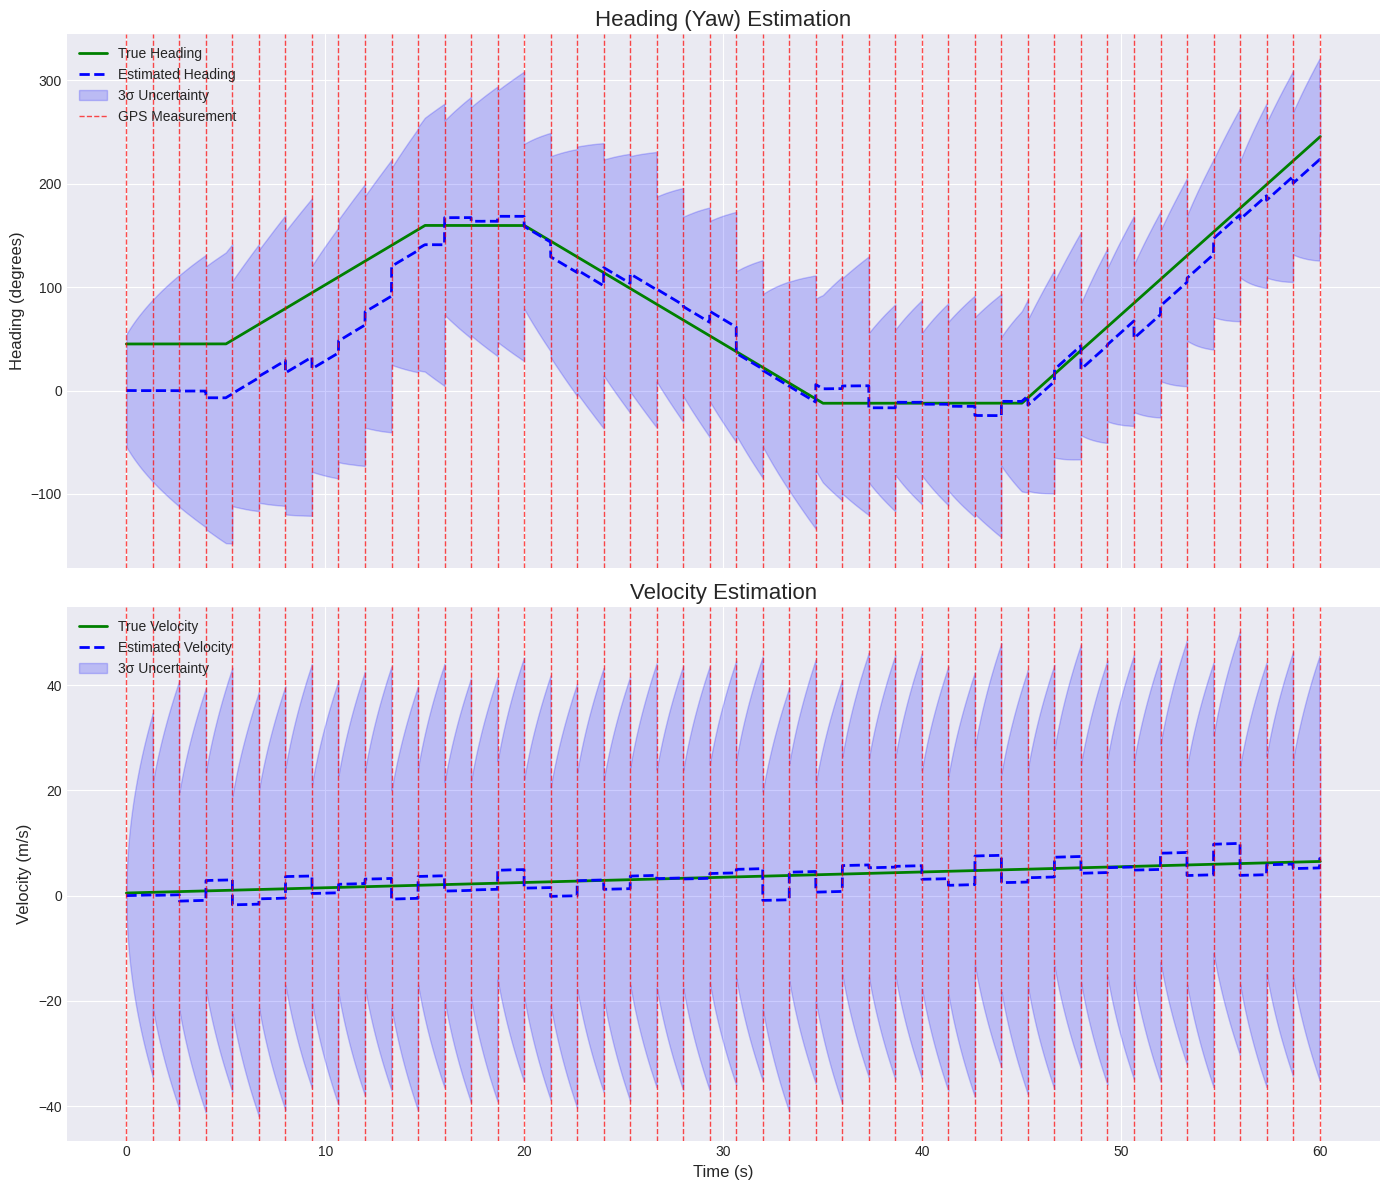

In [ ]:
# Create time axis for plotting
time_axis = np.arange(len(ekf_estimates)) * dt_imu
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
plt.style.use('seaborn-v0_8-darkgrid')

# --- Plot 1: Heading (Yaw) ---

# Extract heading data and unwrap for continuous plotting
true_heading = np.unwrap(ground_truth[:, 2])
est_heading = np.unwrap(ekf_estimates[:, 2])

# Extract heading variance and compute standard deviation
std_heading = np.sqrt(ekf_covariances[:, 2, 2])

axs[0].plot(time_axis, np.rad2deg(true_heading), 'g', label='True Heading', linewidth=2)
axs[0].plot(time_axis, np.rad2deg(est_heading), 'b--', label='Estimated Heading', linewidth=2)
axs[0].fill_between(time_axis,
                    np.rad2deg(est_heading - 3 * std_heading),
                    np.rad2deg(est_heading + 3 * std_heading),
                    color='b', alpha=0.2, label='3σ Uncertainty')
axs[0].set_title('Heading (Yaw) Estimation', fontsize=16)
axs[0].set_ylabel('Heading (degrees)', fontsize=12)
axs[0].legend()
axs[0].grid(True)

# --- Plot 2: Velocity ---

# Extract velocity data
true_velocity = ground_truth[:, 3]
est_velocity = ekf_estimates[:, 3]

# Extract velocity variance and compute standard deviation
std_velocity = np.sqrt(ekf_covariances[:, 3, 3])

axs[1].plot(time_axis, true_velocity, 'g', label='True Velocity', linewidth=2)
axs[1].plot(time_axis, est_velocity, 'b--', label='Estimated Velocity', linewidth=2)
axs[1].fill_between(time_axis,
                    est_velocity - 3 * std_velocity,
                    est_velocity + 3 * std_velocity,
                    color='b', alpha=0.2, label='3σ Uncertainty')
axs[1].set_title('Velocity Estimation', fontsize=16)
axs[1].set_xlabel('Time (s)', fontsize=12)
axs[1].set_ylabel('Velocity (m/s)', fontsize=12)
axs[1].legend()
axs[1].grid(True)

# Draw vertical lines for GPS measurements on both plots
for idx in gps_indices:
    time_of_gps = time_axis[idx]
    axs[0].axvline(x=time_of_gps, color='r', linestyle='--', linewidth=1, alpha=0.7)
    axs[1].axvline(x=time_of_gps, color='r', linestyle='--', linewidth=1, alpha=0.7)

# Create a single legend entry for the GPS lines
axs[0].plot([], [], color='r', linestyle='--', linewidth=1, alpha=0.7, label='GPS Measurement')
axs[0].legend(loc='upper left') # Redraw legend to include the new entry

plt.tight_layout()
plt.show()

## The Heart of the Kalman Filter: Why Your Motion Model Matters

In every Extended Kalman Filter (EKF), there is one component that acts as the system's "crystal ball" 🔮: the **state transition function**, often written as $f(x, u)$. This function is the filter's internal rulebook of physics, its understanding of how the object it's tracking is supposed to move. While we often focus on the fancy matrix math and the sensor updates, the success or failure of your entire filter hinges on how well this single function represents the real-world dynamics of your system.

***

### What is the State Transition Function? The "Rules of Physics"

At its core, the state transition function answers a simple question:

> "Given the system's current state ($x$) and any control inputs it's receiving ($u$), where will it be and how will it be moving a tiny moment ($\Delta t$) into the future?"

* **The State ($x$)** is what you want to know: for our robot, this was its position, orientation, and velocity.
* **The Control Inputs ($u$)** are what you command or measure: for our robot, this was the acceleration and angular velocity from its IMU.
* **The Function ($f$)** is the set of equations that connects them. In our case, this was a set of simple kinematic equations:
    * `new_position = old_position + velocity * Δt`
    * `new_velocity = old_velocity + acceleration * Δt`
    * ...and so on.

For an engineer, the state transition function is where you encode the fundamental principles governing your system—be it kinematics, Newton's laws, orbital mechanics, or electrical circuit laws. It is the **mathematical model of your agent's motion**.

***

### The "Garbage In, Garbage Out" Principle

The EKF operates in a two-step dance: Predict, then Update. The state transition function *is* the prediction step. If your prediction is fundamentally flawed, no amount of sensor correction can truly save it. This is the "Garbage In, Garbage Out" principle applied to system dynamics.

Imagine two scenarios:

1.  **An Overly Simplistic Model:** You write a motion model for a car that only accounts for forward velocity and ignores steering. You feed it accelerometer data but ignore the gyroscope. When the car drives straight, the filter works perfectly. But the moment the car turns, your model will predict that it continued straight ahead. When the next GPS measurement arrives showing the car is 50 meters to the left, the filter will be massively "surprised." This huge error (or "innovation") can cause instability and poor performance because the filter's core assumption about the system's behavior was wrong.

2.  **A Fundamentally Incorrect Model:** You are tasked with tracking a quadrotor drone, but you use the motion model we developed for a wheeled robot. Your model has no concept of lift, thrust, or gravity. It will predict the drone's motion as if it were rolling on the ground. This filter will fail completely and immediately because its internal "rules of physics" do not match the reality of the drone's flight.

The propagation step doesn't just move the state forward; it also projects the uncertainty (the covariance matrix) forward. If the underlying model is wrong, the filter's estimate of its own uncertainty will also be wrong, leading it to become **confidently incorrect**.

***

### Universal Importance: From Cars to Spacecraft

The beauty of the EKF framework is that the *concept* is universal, even if the state transition function `f` is radically different for each application. The principle that the model must accurately reflect reality always remains.

* **For our Wheeled Robot:** The function `f` was based on 2D kinematics.
* **For a Quadrotor Drone:** `f` would be far more complex, involving 3D kinematics, aerodynamics, thrust models, and the force of gravity.
* **For an Orbiting Satellite:** `f` would be dominated by the laws of orbital mechanics, with the primary force being Earth's gravity. Its "control inputs" would be tiny bursts from its thrusters.
* **For a Human Arm:** `f` would be a biomechanical model, describing how muscle activations (inputs) lead to changes in joint angles and limb positions (the state).

In every case, the engineer's first and most critical job is not just to plug in sensor data, but to derive a state transition function that is a faithful, if simplified, representation of the system's true dynamics.

**In conclusion,** think of the Kalman filter as an optimal partnership. The **state transition function ($f$)** provides the theory—the physics-based prediction of what *should* happen. The **sensor measurements ($y$)** provide the evidence—the grounding in what *actually* happened. If your theory is broken, the filter cannot properly interpret the evidence, and the elegant mathematics that tie them together will fall apart.

### Our EKF's Prediction Step: A Practical Inertial Navigation System (INS)

In our project, we've built more than just a filter; we've implemented a complete, albeit simplified, **Inertial Navigation System (INS)** and integrated it with GPS data. Understanding how the IMU-driven prediction step functions as an INS is key to grasping the power and limitations of our system.

***

#### What is an INS?

An Inertial Navigation System is a self-contained method of calculating a vehicle's position, orientation, and velocity without needing any external signals (like GPS). It works through a process called "dead reckoning."

1.  **The Heart (The IMU):** The system starts with an Inertial Measurement Unit (IMU), which contains accelerometers to measure linear acceleration and gyroscopes to measure angular velocity. It's the sensory organ that feels motion.

2.  **The Brain (The Processor):** The INS uses a computer to take the high-frequency measurements from the IMU and integrate them over time. It continuously adds up the tiny changes in motion to keep a running tally of the vehicle's state.

Its greatest strength is its complete autonomy—it works in tunnels, underwater, or in space where GPS is unavailable. Its greatest weakness, however, is that it **accumulates error**. Tiny, unavoidable measurement errors in the IMU are integrated over and over, causing the calculated position to "drift" away from reality over time.

***

#### How Our Implementation Fits This Frame

The **prediction step** of our Extended Kalman Filter *is* our INS.

When we defined our state transition function, `f(x, u)`, we created the "brain" for our navigation system. It takes the "senses" from the IMU—forward acceleration ($a_m$) and angular velocity ($\omega_m$)—and applies the rules of 2D kinematics to predict the new state. Every time our EKF loops without a GPS measurement, it is running purely as an INS, using dead reckoning to estimate its path. We saw this in our plots as the uncertainty grew between GPS updates; that growth is the natural drift of our INS.

The GPS, in this context, serves as the external "corrector" that periodically fixes the drift of our INS, creating a system far more robust than either component alone.

***

#### A Simple Model with Room for Growth

The INS we've built is a powerful demonstration, but it's intentionally simple to be educational. For a real-world, high-precision application, this model would be extended significantly. For instance, we currently assume our IMU is perfect aside from some random noise. A more advanced INS model would also include states for:
* **IMU Biases:** A persistent, systematic offset in the sensor readings.
* **Scale Factor Errors:** An error where the sensor's output is not perfectly proportional to the input.
* **Temperature Drift:** The sensor's properties changing as its temperature fluctuates.

By modeling these effects, the EKF can learn and compensate for the specific imperfections of the hardware being used.

***

#### Extending to 3D and Beyond 🚀

The true power of this framework is its adaptability. Our 2D model provides the foundation for much more complex systems.

* **Extension to 3D:** To track a drone or an aircraft, we would expand our model into three dimensions. This would involve:
    * Using the full 3-axis data from the IMU.
    * Expanding the state vector to include pitch and roll angles, as well as vertical position and velocity.
    * Replacing our simple 2D rotation math with more robust 3D rotation representations, like **quaternions**, to avoid issues like gimbal lock.

* **Extension to Different Planets:** What if our robot was on Mars? The fundamental principles of the INS remain, but the environmental parameters within our state transition function `f` must change. The most significant change would be the **force of gravity**. An accelerometer on Earth measures the vehicle's acceleration *plus* the constant pull of gravity ($g \approx 9.8 m/s^2$). An advanced INS must subtract this gravity vector to get the true vehicle acceleration. For a rover on Mars, the `f` function would need to be programmed with Mars's gravity ($g_{Mars} \approx 3.7 m/s^2$).

In every case, the core idea is the same: the INS provides a continuous prediction of motion based on a physical model, but that model must be an accurate representation of the vehicle and its environment to be effective.